In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np

In [2]:
MIN_PTS = 4
EPSILON = 900
X_UNIT, Y_UNIT = 5000, 5000
SPAN_MARGIN = EPSILON/2 + 1
NOISE_LABEL = -2

In [3]:
# read and organize the data as RDD
def parse_line(line):
    return [int(x) for x in line.strip().split()]

dataset = sc.textFile("/Users/apple/spark/data/project/A-sets/a1.txt")\
    .map(parse_line)\
    .zipWithIndex().map(lambda x: (x[1], x[0]))\
    .filter(lambda x: x[0] < 800) # only keep the first 800 points

In [4]:
x_min, x_max = dataset.map(lambda x: x[1][0]).min(), dataset.map(lambda x: x[1][0]).max()
y_min, y_max = dataset.map(lambda x: x[1][1]).min(), dataset.map(lambda x: x[1][1]).max()
print(x_min, x_max, y_min, y_max, '\nlength:', x_max-x_min, y_max-y_min)

x_grid = list(range(x_min, x_max + X_UNIT, X_UNIT))
y_grid = list(range(y_min, y_max + Y_UNIT, Y_UNIT))

area_list = []
area_cnt = 0
for x_idx, x_start in enumerate(x_grid[:-1]):
    for y_idx, y_start in enumerate(y_grid[:-1]):
        x_start_adjusted = x_start - SPAN_MARGIN
        y_start_adjusted = y_start - SPAN_MARGIN
        x_end_adjusted = x_grid[x_idx+1] + SPAN_MARGIN
        y_end_adjusted = y_grid[y_idx+1] + SPAN_MARGIN
        area_list.append([area_cnt, x_start_adjusted, x_end_adjusted, y_start_adjusted, y_end_adjusted])
        area_cnt += 1
assert len(area_list) == (len(x_grid)-1)*(len(y_grid)-1)

# organize the area into an RDD
# area_list_rdd = sc.parallelize(area_list)

35876 65535 39356 56156 
length: 29659 16800


In [5]:
# for each point, find the area it belongs to (a point can belong to multiple areas)
def find_area(point):
    global area_list
    x, y = point
    area_idx_list = []
    for area in area_list:
        if area[1] <= x <= area[2] and area[3] <= y <= area[4]:
            area_idx_list.append(area[0])
    return area_idx_list

data_id_cluster_id_list = dataset.map(lambda x: (x[0], find_area(x[1]), x[1]))
# format: (data_id, 
#          [area_id1, area_id2, ...], 
#          (x, y)
#         )

# convert to: (area_id, [(point_id, (x, y)), (point_id, (x,y)), ...])
area_id_point_id_list = data_id_cluster_id_list.flatMap(
    lambda x: [(area_id, (x[0], x[2])) for area_id in x[1]])\
    .groupByKey().map(lambda x: (x[0], list(x[1])))

In [6]:
# convert the data in an area to a numpy array
# 3 columns: data_id, x, y
def convert_to_np_array(data_list):
    return np.array([[x[0], x[1][0], x[1][1]] for x in data_list])

area_id_np_array = area_id_point_id_list.mapValues(convert_to_np_array)

In [7]:
import numpy as np

def dbscan_inline(data, eps, min_pts):
    '''
    data: np.array, shape=(N, 2)
    eps: float
    min_pts: int
    
    Returns:
    labels: np.array, shape=(N,)
    '''
    def find_neighbors(data, point, eps):
        neighbors_id = []
        for i, p in enumerate(data):
            if np.linalg.norm(p - point) < eps:
                neighbors_id.append(i)
        return neighbors_id
    
    N = data.shape[0]
    labels = np.zeros(N, dtype=int) - 1 # -1: unclassified, -2: noise, 1, 2, 3, ...: cluster id
    c = 0
    for i in range(N):
        if labels[i] != -1:
            continue
        neighbors_id = find_neighbors(data, data[i], eps)
        if len(neighbors_id) < min_pts:
            labels[i] = -2
            continue
        c += 1
        labels[i] = c
        neighbors_id_prime = neighbors_id.copy()
        assert i in neighbors_id_prime
        neighbors_id_prime.remove(i)
        for j in neighbors_id_prime:
            if labels[j] == -2:
                labels[j] = c
            if labels[j] != -1:
                continue
            labels[j] = c
            neighbors_j = find_neighbors(data, data[j], eps)
            if len(neighbors_j) >= min_pts:
                neighbors_id_prime += neighbors_j
    return labels

In [8]:
# for each area, find the points in it and perform local DBSCAN
import sys
def local_dbscan(data, eps, min_pts):
    '''
    data: np.array, shape (n, 3)
    '''
    data_id = data[:, 0]
    data = data[:, 1:]
    # print('will call dbscan with data shape:', data.shape)
    label_pred = dbscan_inline(data, eps, min_pts)
    return list(zip(data_id, label_pred))

data_id_label_pred_list = area_id_np_array.mapValues(lambda x: local_dbscan(x, EPSILON, MIN_PTS))

In [9]:
def transform(i: int, S: int, k, noise_label=-2) -> int:
    '''
    i: split id
    S: total number of splits
    k: the cluster id in split #i
    '''
    if k == noise_label:
        return noise_label
    else:
        return (k-1)*S + i

In [29]:
S = len(area_list)
print('S:', S)
data_id_corrected_label_pred_list = data_id_label_pred_list.map(lambda x: (x[0], [(y[0], transform(x[0], S, y[1])) for y in x[1]]))\
    .flatMap(lambda x: x[1])\
    .map(lambda x: (x[0], [x[1]]))\
    .reduceByKey(lambda x, y: x + y)\
    .sortByKey().cache()
    # key = data_id, value = [label1, label2, ...]
set_list = data_id_corrected_label_pred_list.filter(lambda x: len(set(x[1])) > 1).collect()

def select_temp_label(label_list):
    label_list = sorted(label_list)
    if len(label_list) == 1:
        return label_list[0]
    else:
        return label_list[1]
data_id_temp_label = data_id_corrected_label_pred_list.mapValues(select_temp_label)

S: 24


In [32]:
# not_noise_data_cluster = dict()
real_set_list = []
for data_id, cluster_list in set_list:
    if NOISE_LABEL in cluster_list:
        cluster_list.remove(NOISE_LABEL)
        assert NOISE_LABEL not in cluster_list
        # not_noise_data_cluster[data_id] = cluster_list[0]
    cluster_set = set(cluster_list)
    if cluster_set not in real_set_list:
        real_set_list.append(cluster_set)
# print('real_set_list:', real_set_list)

def merge_intersecting_sets(set_list):
        merged_sets = []
        while set_list:
            current_set = set_list.pop(0)  # 从list中取出一个集合
            merged = None
            # 查找第一个与current_set有交集的集合
            for i, merged_set in enumerate(merged_sets):
                if merged_set & current_set:
                    merged_set.update(current_set)
                    merged = i
                    break
            if merged is None:  # 没有发现交集
                merged_sets.append(current_set)
            else:  # 发现交集，再次合并可能的交集
                new_merged_set = merged_sets.pop(merged)
                set_list.append(new_merged_set)  # 将更新后的集合重新加入检查
        return merged_sets

merged_set_list = merge_intersecting_sets(real_set_list)
print('merged_set_list:', merged_set_list)
# print('not_noise_data_cluster:', not_noise_data_cluster)

cluster_map = dict()
for merged_set in merged_set_list:
    if len(merged_set) < 2:
        continue
    merged_set = list(merged_set)
    for i in range(1, len(merged_set)):
        cluster_map[merged_set[i]] = merged_set[0]
print('cluster_map:', cluster_map)

merged_set_list: [{16, 17, 12, 13}, {37, 9, 10, 14}, {0, 33, 1, 4, 5, 8}, {40, 41, 43, 18, 19, 20, 21, 22, 23}]
cluster_map: {17: 16, 12: 16, 13: 16, 9: 37, 10: 37, 14: 37, 33: 0, 1: 0, 4: 0, 5: 0, 8: 0, 41: 40, 43: 40, 18: 40, 19: 40, 20: 40, 21: 40, 22: 40, 23: 40}


In [33]:
# map and find the final cluster
def get_final_cluster(in_label):
    global cluster_map
    if cluster_map.get(in_label) is not None:
        return cluster_map[in_label]
    else:
        return in_label

data_id_final_cluster = data_id_temp_label.mapValues(get_final_cluster)

In [36]:
import sys
sys.path.append('..')
from utils import visualization

In [42]:
dataset_array = np.array(dataset.values().collect())
dataset_array

array([[54620, 43523],
       [52694, 42750],
       [53253, 43024],
       ...,
       [40028, 44930],
       [37346, 45508],
       [38863, 44153]])

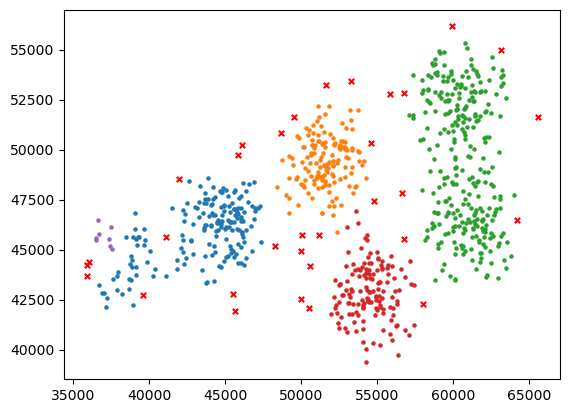

In [46]:
visualization.visualize_dataset_with_label(dataset_array, np.array(data_id_final_cluster.values().collect()))